# This script is organized as the following:
## 1) Data cleaning
## 2) Data exploration
## 3) Statistical testing
### 3.1) Stationary test
### 3.2) ACF/PACF plots
## 4) Model building
## 5) Forecasting

#### NOTE: If you want to quickly see the overview, just go to the end and read the summary

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt
import pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import statsmodels.api as sm  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1) Data cleaning
### - Date column is not in date format
### - Some dates are missing, i.e. category L only has half of the dates
### - Note: we are going to forecast 90 days ahead, so our basic unit is day not hours. So we will group the data into daily sales

In [2]:
np.random.seed(42)
data = pd.read_csv('../data/siteA.csv')

In [3]:
data['Date_Name'] = data['Date_Name'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

In [4]:
print data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66160 entries, 0 to 66159
Data columns (total 4 columns):
Date_Name        66160 non-null datetime64[ns]
subCategory      66160 non-null object
Purchase_Hour    66160 non-null int64
sales            66160 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.0+ MB
None


In [5]:
data.head()

,Date_Name,subCategory,Purchase_Hour,sales
0,2016-02-10,A,20,8.34
1,2016-02-07,A,15,5.84
2,2016-02-28,A,18,7.38
3,2015-09-28,A,7,12.30
4,2015-09-29,A,7,24.03


In [6]:
# Group by and sum()

def func_sum(df):
    return sum(df['sales'])
temp = data.groupby(by=['Date_Name', 'subCategory']).apply(func_sum)
print temp.head()
print type(temp)

Date_Name   subCategory
2015-09-26  A                66.52
            B              1181.95
            C               713.04
            D                89.00
            E               467.63
dtype: float64
<class 'pandas.core.series.Series'>


In [7]:
# Convert grouped series back to dataframe.

temp_df = pd.DataFrame(data={'sales': temp})
temp_df.reset_index(inplace=True)
print temp_df.head()
print temp_df.shape
print temp_df.columns

   Date_Name subCategory    sales
0 2015-09-26           A    66.52
1 2015-09-26           B  1181.95
2 2015-09-26           C   713.04
3 2015-09-26           D    89.00
4 2015-09-26           E   467.63
(5259, 3)
Index([u'Date_Name', u'subCategory', u'sales'], dtype='object')


In [8]:
print temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5259 entries, 0 to 5258
Data columns (total 3 columns):
Date_Name      5259 non-null datetime64[ns]
subCategory    5259 non-null object
sales          5259 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 123.3+ KB
None


In [9]:
temp_df[temp_df['sales'] == 0]

,Date_Name,subCategory,sales


In [10]:
temp_df['summer'] = 0
temp_df.head()

,Date_Name,subCategory,sales,summer
0,2015-09-26,A,66.52,0
1,2015-09-26,B,1181.95,0
2,2015-09-26,C,713.04,0
3,2015-09-26,D,89.00,0
4,2015-09-26,E,467.63,0


In [11]:
# Feature engineering - summer or not

summer_starts = datetime.date(2016, 5, 1)
summer_ends = datetime.date(2016, 9, 1)
temp_df.loc[(temp_df['Date_Name'] >= summer_starts) & (temp_df['Date_Name'] < summer_ends), 'summer'] = 1
print temp_df[(temp_df['Date_Name'] >= summer_starts) & (temp_df['Date_Name'] < summer_ends)].head()
print temp_df.head()

      Date_Name subCategory    sales  summer
3206 2016-05-02           A    19.59       1
3207 2016-05-02           B  1696.36       1
3208 2016-05-02           C   544.14       1
3209 2016-05-02           D    30.09       1
3210 2016-05-02           E    63.37       1
   Date_Name subCategory    sales  summer
0 2015-09-26           A    66.52       0
1 2015-09-26           B  1181.95       0
2 2015-09-26           C   713.04       0
3 2015-09-26           D    89.00       0
4 2015-09-26           E   467.63       0


In [12]:
# Feature engineering - weekend or not

temp_df['weekend'] = map(lambda x: x.weekday(), temp_df['Date_Name'])
print temp_df.head()
print temp_df.tail()

   Date_Name subCategory    sales  summer  weekend
0 2015-09-26           A    66.52       0        5
1 2015-09-26           B  1181.95       0        5
2 2015-09-26           C   713.04       0        5
3 2015-09-26           D    89.00       0        5
4 2015-09-26           E   467.63       0        5
      Date_Name subCategory     sales  summer  weekend
5254 2016-09-30           M  10643.42       0        4
5255 2016-09-30           N  11572.01       0        4
5256 2016-09-30           O  11023.42       0        4
5257 2016-09-30           P     68.59       0        4
5258 2016-09-30           Q     14.49       0        4


In [13]:
# Feature engineering - extract Month and Day

temp_df['month'] = map(lambda x: x.month, temp_df['Date_Name'])
temp_df['day'] = map(lambda x: x.day, temp_df['Date_Name'])
print temp_df.head()
print temp_df.tail()

   Date_Name subCategory    sales  summer  weekend  month  day
0 2015-09-26           A    66.52       0        5      9   26
1 2015-09-26           B  1181.95       0        5      9   26
2 2015-09-26           C   713.04       0        5      9   26
3 2015-09-26           D    89.00       0        5      9   26
4 2015-09-26           E   467.63       0        5      9   26
      Date_Name subCategory     sales  summer  weekend  month  day
5254 2016-09-30           M  10643.42       0        4      9   30
5255 2016-09-30           N  11572.01       0        4      9   30
5256 2016-09-30           O  11023.42       0        4      9   30
5257 2016-09-30           P     68.59       0        4      9   30
5258 2016-09-30           Q     14.49       0        4      9   30


In [14]:
temp_df['subCategory'] = temp_df['subCategory'].astype('category').cat.codes
print temp_df.head()

   Date_Name  subCategory    sales  summer  weekend  month  day
0 2015-09-26            0    66.52       0        5      9   26
1 2015-09-26            1  1181.95       0        5      9   26
2 2015-09-26            2   713.04       0        5      9   26
3 2015-09-26            3    89.00       0        5      9   26
4 2015-09-26            4   467.63       0        5      9   26


(345,)
(345,)


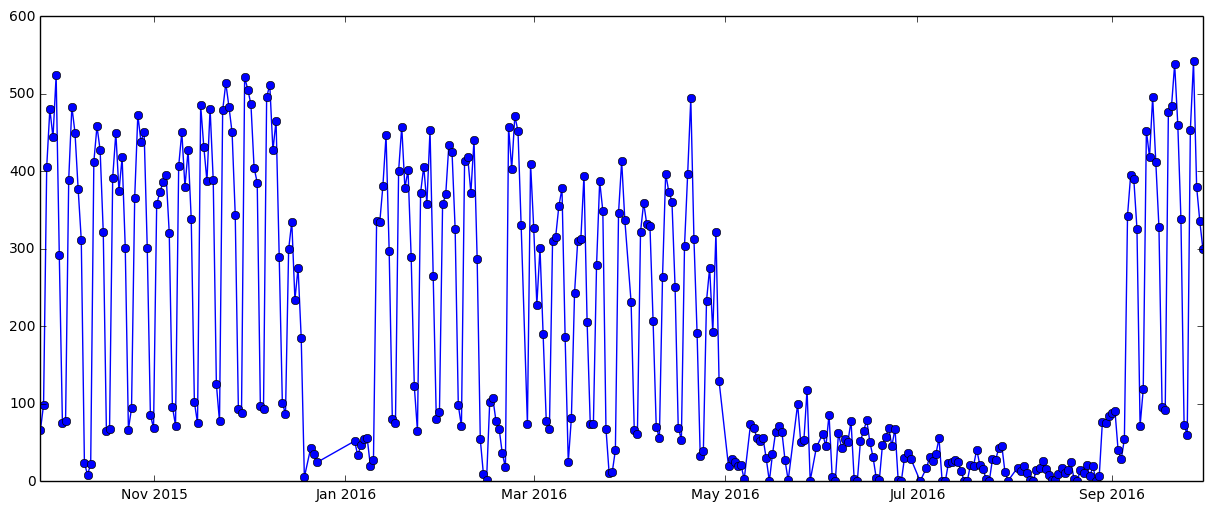

In [15]:
cat_A = temp_df[temp_df['subCategory']==0]
print cat_A['Date_Name'].shape
print cat_A['sales'].shape

plt.plot(cat_A['Date_Name'], cat_A['sales'], '-o')

# XGBoost

In [16]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
train = temp_df[['Date_Name', 'subCategory', 'summer', 'weekend', 'sales', 'month', 'day']]

In [18]:
train['Date_Name'] = (temp_df['Date_Name']-temp_df['Date_Name'].min()).astype('timedelta64[D]').astype(int)+1

In [19]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.2,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "thread": 1,
          "seed": 2015
          }

X_train, X_test = train_test_split(train, test_size=0.10, random_state=10)
y_train = np.array(X_train.sales)
y_test = np.array(X_test.sales)
X_train = X_train[['Date_Name', 'subCategory', 'summer', 'weekend', 'month', 'day']]
X_test = X_test[['Date_Name', 'subCategory', 'summer', 'weekend', 'month', 'day']]

In [51]:
# Grid Search with XGBoost. Tuning max_depth & min_child_weight
xgb_model = XGBRegressor()
xgb_params = {'max_depth': [6, 9], \
              'subsample': [0.7], \
              'n_estimators': [100, 500], \
              'learning_rate': [0.01], \
              'colsample_bytree': [0.6], \
              'min_child_weight': [1, 1.25], \
              'gamma': [0], \
              'scale_pos_weight': [1], \
              'reg_lambda':[0.9], \
              'seed': [42]
             }
# colsample_bytree = sqrt(288) = 17, because 288 features
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, verbose=1, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)
score = xgb_grid.cv_results_
print("Score: ", score)
print("mean_test_score: ", score['mean_test_score'])

mean_test_score = score['mean_test_score'].mean()
print("Average mean_test_score: ", mean_test_score)

xgb_pred = xgb_grid.predict(X_test) # This is the input training set for our stacked model.
print xgb_pred
np.savetxt('xgb_test_pred_2.txt', xgb_pred)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   12.6s finished


('Score: ', {'std_train_score': array([ 732229.38575327,  437992.5328294 ,  730861.19455028,
        442324.91752591,  563970.28666899,  184252.64211101,
        576454.80113899,  195549.3825644 ]), 'rank_test_score': array([7, 3, 8, 4, 5, 1, 6, 2], dtype=int32), 'param_max_depth': masked_array(data = [6 6 6 6 9 9 9 9],
             mask = [False False False False False False False False],
       fill_value = ?)
, 'split1_train_score': array([-11087172.37225179,  -3009059.06047553, -11091431.52427666,
        -3026120.37103523,  -9800818.953461  ,  -1513464.38954606,
        -9836242.95327022,  -1599001.73327445]), 'param_gamma': masked_array(data = [0 0 0 0 0 0 0 0],
             mask = [False False False False False False False False],
       fill_value = ?)
, 'split2_train_score': array([-11697283.11000357,  -2720039.7273295 , -11699461.62522301,
        -2730226.63894931, -10654461.99635017,  -1471391.473147  ,
       -10703510.26246388,  -1572553.08451038]), 'param_subsample': mas

In [52]:
# Pretty printing the results.
print(xgb_grid.best_params_)
print(xgb_grid.best_score_, np.sqrt(-xgb_grid.best_score_))
print'\n'
print(score['params'])
df = pd.DataFrame()
df['rmse_train_score'] = np.sqrt(-score['mean_train_score'])
df['rmse_test_score'] = np.sqrt(-score['mean_test_score'])
print'\n'
print(df)

{'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 9, 'gamma': 0}
(-2774307.817099561, 1665.6253531630578)


({'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 6, 'gamma': 0}, {'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 6, 'gamma': 0}, {'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1.25, 'n_estimators': 100, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 6, 'gamma': 0}, {'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1.25, 'n_estimators': 500, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth

# MSE: almost perfect fit is 6000 something
## Without 'month', 'day', is 2,710,854

In [53]:
# Benchmark RMSE 2: 1159.174395936485
# Benchmark RMSE: 1654.364
sqrt(mean_squared_error(y_test, xgb_pred))

1345.2781970190435

Train:  (4733, 6)
Test:  (526, 6)


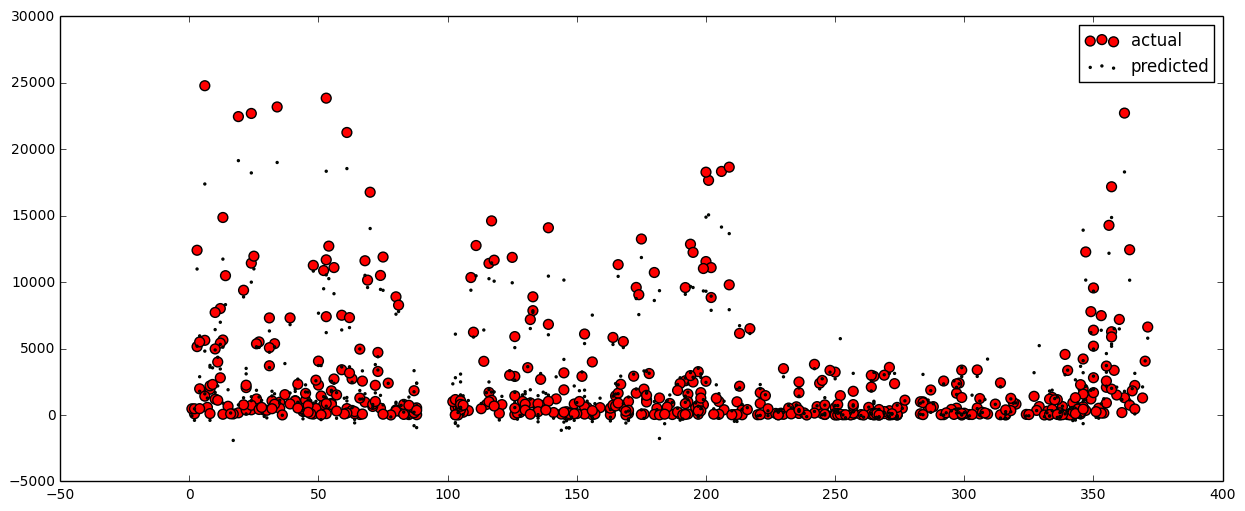

In [54]:
print 'Train: ', X_train.shape
print 'Test: ', X_test.shape
plt.scatter(X_test['Date_Name'], y_test, c='red', s=50, label='actual')
plt.scatter(X_test['Date_Name'], xgb_pred, c='green', s=2, label='predicted')
plt.legend()

In [55]:
print train.tail(16)
np.sort(train['subCategory'].unique())

      Date_Name  subCategory  summer  weekend     sales  month  day
5243        371            0       0        4    299.56      9   30
5244        371            1       0        4   6623.06      9   30
5245        371            2       0        4   2506.76      9   30
5246        371            3       0        4    782.44      9   30
5247        371            4       0        4    621.09      9   30
5248        371            5       0        4  16210.05      9   30
5249        371            6       0        4   2413.91      9   30
5250        371            7       0        4   6004.38      9   30
5251        371            8       0        4   2034.84      9   30
5252        371            9       0        4   1024.24      9   30
5253        371           10       0        4   1092.61      9   30
5254        371           11       0        4  10643.42      9   30
5255        371           12       0        4  11572.01      9   30
5256        371           13       0        4  1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [56]:
# Create 90 days ahead dataframe for prediction.

idx = pd.date_range('10-01-2016', '12-30-2016')
new_idx = []
for day, item in enumerate(idx):
    for i in range(0, 16):
        new_idx.append(item)


future_df = pd.DataFrame(data={'Date_Name': new_idx})
print day
print future_df.head()
print future_df.shape
print future_df.tail()

subCategory = range(0, 16)*91
future_df['subCategory'] = subCategory

# New features: summer and weekend.
future_df['summer'] = 0
# summer_starts = datetime.date(2017, 5, 1)
# summer_ends = datetime.date(2017, 9, 1)
# future_df.loc[(future_df['Date_Name'] >= summer_starts) & (future_df['Date_Name'] < summer_ends), 'summer'] = 1
# print future_df[(future_df['Date_Name'] >= summer_starts) & (future_df['Date_Name'] < summer_ends)].head()
# print future_df.head()

# Weekend.
future_df['weekend'] = map(lambda x: x.weekday(), future_df['Date_Name'])

# Feature engineering - extract Month and Day
future_df['month'] = map(lambda x: x.month, future_df['Date_Name'])
future_df['day'] = map(lambda x: x.day, future_df['Date_Name'])

# Convert date to numerical sequence.
future_df['Date_Name'] = (future_df['Date_Name']-future_df['Date_Name'].min()).astype('timedelta64[D]').astype(int)+372

print future_df.head()
print future_df.tail()

90
   Date_Name
0 2016-10-01
1 2016-10-01
2 2016-10-01
3 2016-10-01
4 2016-10-01
(1456, 1)
      Date_Name
1451 2016-12-30
1452 2016-12-30
1453 2016-12-30
1454 2016-12-30
1455 2016-12-30
   Date_Name  subCategory  summer  weekend  month  day
0        372            0       0        5     10    1
1        372            1       0        5     10    1
2        372            2       0        5     10    1
3        372            3       0        5     10    1
4        372            4       0        5     10    1
      Date_Name  subCategory  summer  weekend  month  day
1451        462           11       0        4     12   30
1452        462           12       0        4     12   30
1453        462           13       0        4     12   30
1454        462           14       0        4     12   30
1455        462           15       0        4     12   30


In [57]:
xgb_90 = xgb_grid.predict(future_df)

In [58]:
print type(xgb_90)
final_df = pd.DataFrame(data=future_df)
final_df['sales'] = xgb_90
future_df = future_df.drop('sales', axis=1)
print 'Final: \n', final_df.head()
print 'Future: \n', future_df.head()

<type 'numpy.ndarray'>
Final: 
   Date_Name  subCategory  summer  weekend  month  day        sales
0        372            0       0        5     10    1   132.976425
1        372            1       0        5     10    1  2606.438477
2        372            2       0        5     10    1  1049.957520
3        372            3       0        5     10    1   281.831604
4        372            4       0        5     10    1   355.746399
Future: 
   Date_Name  subCategory  summer  weekend  month  day
0        372            0       0        5     10    1
1        372            1       0        5     10    1
2        372            2       0        5     10    1
3        372            3       0        5     10    1
4        372            4       0        5     10    1


In [59]:
final_df = final_df.groupby(by=['Date_Name'])['sales'].sum()
print final_df.head()
old_sales = train.groupby(by=['Date_Name'])['sales'].sum()
print old_sales.head()

Date_Name
372    30603.720703
373    31114.539062
374    74467.289062
375    81709.250000
376    85429.781250
Name: sales, dtype: float32
Date_Name
1    14588.23
2    15143.61
3    84535.83
4    94145.18
5    91173.07
Name: sales, dtype: float64


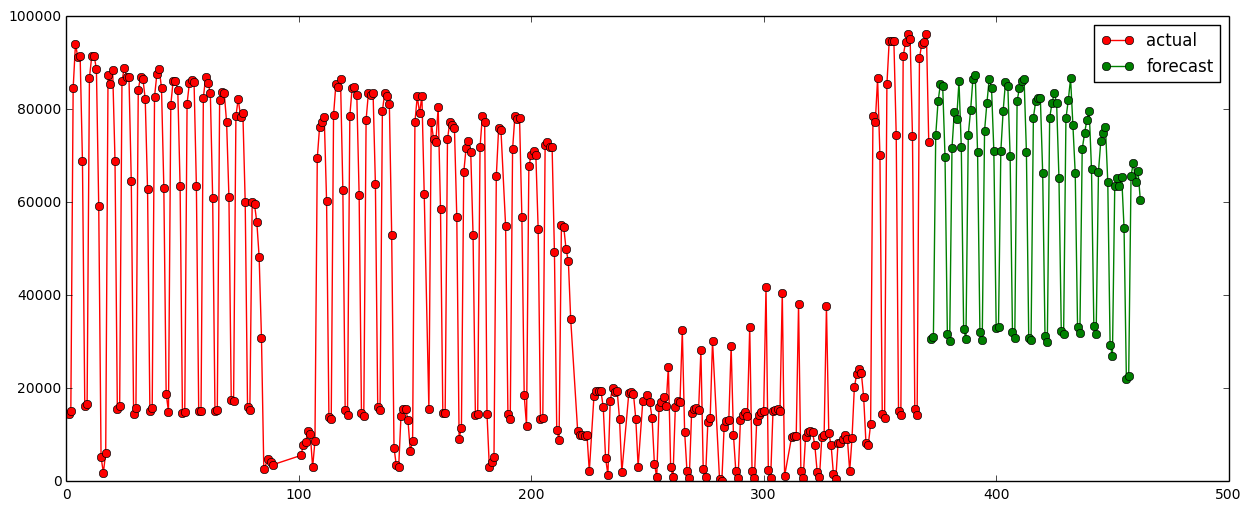

In [60]:
plt.plot(old_sales.index, old_sales, '-o', c='red', label='actual')
plt.plot(final_df.index, final_df, '-o', c='green', label='forecast')
plt.legend()

In [61]:
xgb_in_sample = xgb_grid.predict(train[['Date_Name', 'subCategory', 'summer', 'weekend', 'month', 'day']])

In [62]:
# Benchmark RMSE 2: 713.1613025362668
# Benchmark RMSE: 1657.888
sqrt(mean_squared_error(train['sales'], xgb_in_sample))

1202.218861734859

In [63]:
print type(xgb_in_sample)
in_sample_df = pd.DataFrame(data=train[['Date_Name', 'subCategory', 'summer', 'weekend', 'month', 'day']])
in_sample_df['sales'] = xgb_in_sample
print 'Train: \n', train.head()
print 'In Sample: \n', in_sample_df.head()

in_sample_df = in_sample_df.groupby(by=['Date_Name'])['sales'].sum()
print in_sample_df.head()

<type 'numpy.ndarray'>
Train: 
   Date_Name  subCategory  summer  weekend    sales  month  day
0          1            0       0        5    66.52      9   26
1          1            1       0        5  1181.95      9   26
2          1            2       0        5   713.04      9   26
3          1            3       0        5    89.00      9   26
4          1            4       0        5   467.63      9   26
In Sample: 
   Date_Name  subCategory  summer  weekend  month  day        sales
0          1            0       0        5      9   26  -256.943939
1          1            1       0        5      9   26  1343.761841
2          1            2       0        5      9   26   441.798767
3          1            3       0        5      9   26  -196.741196
4          1            4       0        5      9   26   -67.336075
Date_Name
1    15209.885742
2    16082.518555
3    81996.281250
4    94869.859375
5    90041.640625
Name: sales, dtype: float32


In [64]:
# Benchmark RMSE 2: 1540.270
# Benchmark RMSE: 2864.868
sqrt(mean_squared_error(old_sales, in_sample_df))

3040.35095795879

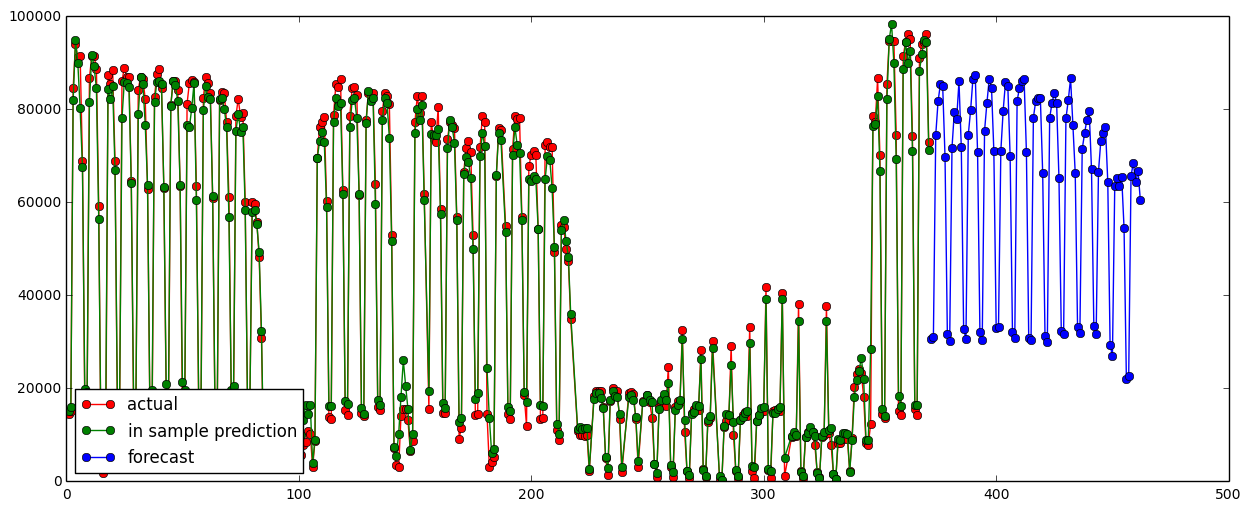

In [65]:
# After Gridsearch Tuning 2nd time. Parameters used:
# xgb_params = {'colsample_bytree': 0.6, 
#                 'scale_pos_weight': 1, 
#                 'learning_rate': 0.01, 
#                 'min_child_weight': 1, 
#                 'n_estimators': 500, 
#                 'subsample': 0.7, 
#                 'reg_lambda': 0.9, 
#                 'seed': 42, 
#                 'max_depth': 9, 
#                 'gamma': 0}
# (-2774307.817099561, 1665.6253531630578)

plt.plot(old_sales.index, old_sales, '-o', c='red', label='actual')
plt.plot(in_sample_df.index, in_sample_df, '-o', c='green', label='in sample prediction')
plt.plot(final_df.index, final_df, '-o', c='blue', label='forecast')
plt.legend(loc='lower left')

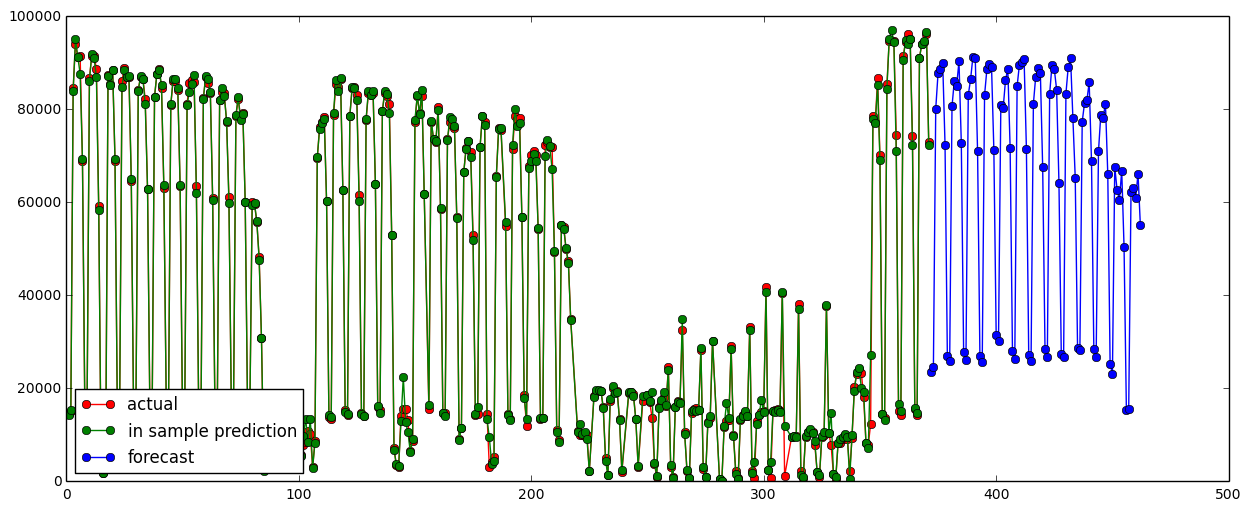

In [50]:
# After Gridsearch Tuning
# xgb_params = {'max_depth': [6], \
#               'subsample': [0.7], \
#               'n_estimators': [500], \
#               'learning_rate': [0.01], \
#               'colsample_bytree': [0.6], \
#               'min_child_weight': [1.25], \
#               'gamma': [0], \
#               'scale_pos_weight': [1], \
#               'reg_lambda':[0.9], \
#               'seed': [42]
#              }

plt.plot(old_sales.index, old_sales, '-o', c='red', label='actual')
plt.plot(in_sample_df.index, in_sample_df, '-o', c='green', label='in sample prediction')
plt.plot(final_df.index, final_df, '-o', c='blue', label='forecast')
plt.legend(loc='lower left')

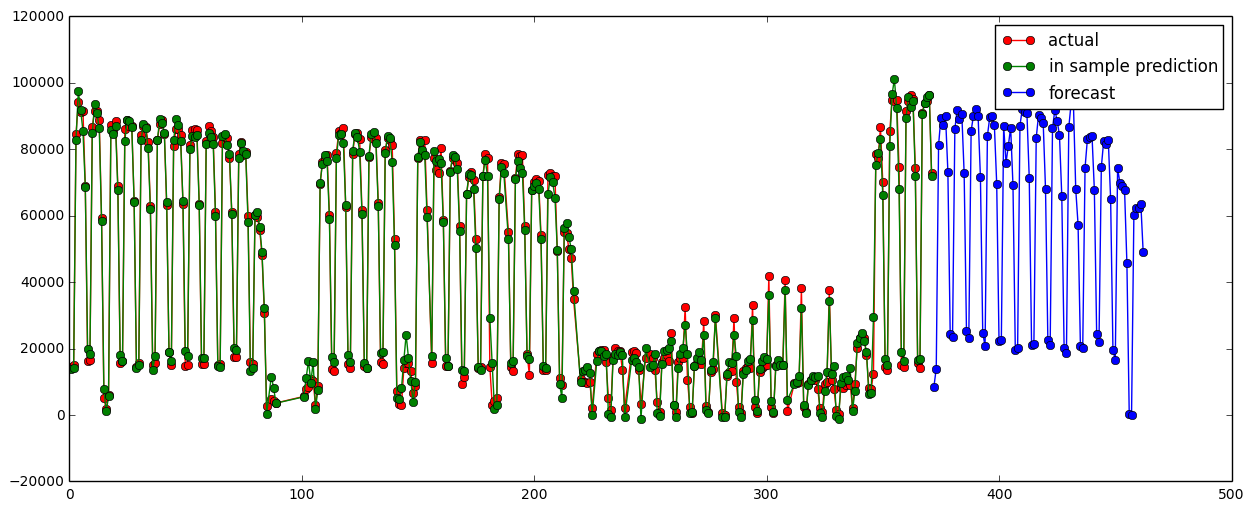

In [33]:
# Before Gridsearch Tuning. Parameters used:
# xgb_params = {'max_depth': [3], \
#               'subsample': [0.7], \
#               'n_estimators': [5003], \
#               'learning_rate': [0.01], \
#               'colsample_bytree': [0.6], \
#               'min_child_weight': [1.25], \
#               'gamma': [0], \
#               'scale_pos_weight': [1], \
#               'reg_lambda':[0.9], \
#               'seed': [42]
#              }

plt.plot(old_sales.index, old_sales, '-o', c='red', label='actual')
plt.plot(in_sample_df.index, in_sample_df, '-o', c='green', label='in sample prediction')
plt.plot(final_df.index, final_df, '-o', c='blue', label='forecast')
plt.legend()